# Analysis for Differential Jet Mass in Z+Jets events with NanoAODv9

In [1]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import pickle
import dask
#from distributed.diagnostics.plugin import UploadDirectory
import os
#from cms_utils import *
print("numpy version", np.__version__)
print("dask version", dask.__version__)

awkward version  1.10.3
coffea version  0.7.22
numpy version 1.23.5
dask version 2023.3.1


### Automatically reload any modules used

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from smp_utils import *
from cms_utils import *
from response_maker_nanov9_lib import *
from response_maker_nanov9 import *

In [4]:
#f = uproot.open("root://xcache//store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/260000/18D0A087-30BD-FE4E-B447-5F493C2D2794.root")

In [5]:
#f["Events"].keys()

In [6]:
# from dask.distributed import Client

# client = Client("tls://192.168.86.46:8786")
# client

# client.register_worker_plugin(UploadDirectory("/home/ZJet/QJetMassUproot/", restart=True, update_path=True))
# #print(client.run(os.listdir, "dask-worker-space") )
# client.scheduler_info()['workers']

In [7]:
from distributed import Client
from lpcjobqueue import LPCCondorCluster

cluster = LPCCondorCluster(transfer_input_files = ["data", "correctionFiles", "jsonpog-integration","samples", "response_maker_nanov9.ipynb", "response_maker_nanov9_lib.py","smp_utils.py","cms_utils.py", "weight_class.py"], 
                           ship_env = False,
                           memory = "9GB")
cluster.adapt(minimum=0, maximum=1000)

#client.register_worker_plugin(UploadDirectory('zjet',restart=True,update_path=True),nanny=True)


In [ ]:
# client.register_worker_plugin(UploadDirectory("/home/ZJet/QJetMassUproot/", restart=True, update_path=True), nanny=True)
# #print(client.run(os.listdir, "dask-worker-space") )

### If desired, uncomment these to move or remove old pkl files

In [ ]:
#! mv qjetmass_zjets_gen.pkl qjetmass_zjets_gen_old.pkl
#! mv qjetmass_zjets_reco.pkl qjetmass_zjets_reco_old.pkl

In [ ]:
# client.scheduler_info()['workers']

### If you want to rerun, here is the line. Otherwise keep it commented to just read the pkl file. 

In [ ]:
#client = Client(cluster)
#print(client.run(os.listdir) )
#client.scheduler_info()['workers']

In [ ]:

with Client(cluster) as client:    
    response_maker_nanov9(testing= False, do_gen=True, client=client, prependstr="root://cmsxrootd.fnal.gov/")
    #response_maker_nanov9(testing=False, do_gen=False, client=client)

Running...
[                                        ] | 0% Completed | 15min 14.2s

In [ ]:
#fout = uproot.recreate("skimmed_mc.root")

In [ ]:
#response_maker_nanov9(testing=False, do_gen=True, client=None, prependstr="/mnt/data/cms", skimfilename="skimmed_mc.root")

In [ ]:
#response_maker_nanov9(testing=False, do_gen=True, client=None, prependstr="", skimfilename="skimmed_mc")

In [ ]:
#f = uproot.open("skimmed_mc.root")

In [ ]:
#f = uproot.open("skimmed_data.root")

In [ ]:
#response_maker_nanov9(testing=True, do_gen=False, client=None, prependstr="/mnt/data/cms")

In [ ]:
#len(f["Events"]['reco_jet_pt'].arrays())

### Open pkl file for the output histograms

In [15]:
with open("qjetmass_zjets_gen.pkl", "rb") as f:
    output = pickle.load( f )

In [16]:
output.keys()

dict_keys(['njet_gen', 'njet_reco', 'ptjet_gen_pre', 'ptjet_mjet_u_gen', 'ptjet_mjet_u_reco', 'ptjet_mjet_g_gen', 'ptjet_mjet_g_reco', 'ptjet_reco_over_gen', 'drjet_reco_gen', 'ptz_gen', 'ptz_reco', 'mz_gen', 'mz_reco', 'mz_reco_over_gen', 'fakes', 'misses', 'dr_z_jet_gen', 'dr_z_jet_reco', 'dphi_z_jet_gen', 'dphi_z_jet_reco', 'ptasym_z_jet_gen', 'ptasym_z_jet_reco', 'ptfrac_z_jet_gen', 'ptfrac_z_jet_reco', 'm_u_jet_reco_over_gen', 'm_g_jet_reco_over_gen', 'dr_gen_subjet', 'dr_reco_to_gen_subjet', 'response_matrix_u', 'response_matrix_g', 'cutflow'])

In [17]:
output["cutflow"]

{'UL2018': defaultdict(int,
             {'all events': 5000,
              'weights cut': 4915,
              'npv': 983,
              'oneGenJet': 983,
              'matches': 843,
              'twoGen_ee': 131,
              'twoGen_mm': 189,
              'twoGen_leptons': 320,
              'z_ptcut_gen': 270,
              'z_mcut_gen': 287,
              'z_jet_dphi_sel_gen': 659,
              'z_pt_asym_sel_gen': 82,
              'kinsel_gen': 247,
              'toposel_gen': 62,
              'allsel_gen': 35,
              'twoReco_ee': 41,
              'twoReco_mm': 57,
              'twoReco_leptons': 98,
              'z_ptcut_reco': 405,
              'z_mcut_reco': 190,
              'oneRecoJet': 983,
              'z_jet_dphi_sel_reco': 535,
              'z_pt_asym_sel_reco': 68,
              'kinsel_reco': 76,
              'toposel_reco': 42,
              'presel_reco': 12,
              'allsel_reco': 9,
              'fakes': 2,
              'matched_rec

In [18]:
output['response_matrix_g']

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 31312055.0: TOOL at 131.225.189.103 failed to send file(s) to <131.225.204.62:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpbpuvxe14/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK8PFPuppi.junc.txt; SCHEDD at 131.225.204.62 - |Error: receiving file /storage/local/data1/condor/spool/2055/0/cluster31312055.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK4PFchs.junc.txt


Hist(
  StrCategory(['UL2018'], growth=True, name='dataset', label='Primary dataset'),
  Variable([200, 260, 350, 460, 550, 650, 760, 13000], name='ptreco', label='p_{T,RECO} (GeV)'),
  Variable([0, 5, 10, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 1000], name='mreco', label='m_{RECO} (GeV)'),
  Variable([200, 260, 350, 460, 550, 650, 760, 13000], name='ptgen', label='p_{T,RECO} (GeV)'),
  Variable(array([   0. ,    2.5,    5. ,    7.5,   10. ,   15. ,   20. ,   30. ,
         40. ,   50. ,   60. ,   70. ,   80. ,   90. ,  100. ,  125. ,
        150. ,  175. ,  200. ,  225. ,  250. ,  275. ,  300. ,  325. ,
        350. , 1000. ]), name='mgen', label='Mass [GeV]'),
  StrCategory(['nominal', 'puUp', 'puDown', 'elerecoUp', 'elerecoDown', 'murecoUp', 'murecoDown', 'JES_up', 'JES_down', 'JER_up', 'JER_down'], growth=True, name='systematic', label='Systematic Uncertainty'),
  storage=Weight()) # Sum: WeightedSum(value=0.0317358, variance=8.6371e-06)

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 31312056.0: TOOL at 131.225.189.103 failed to send file(s) to <131.225.204.62:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpbpuvxe14/correctionFiles/JEC/Summer19UL16APV_RunEF_V7_DATA/Summer19UL16APV_RunEF_V7_DATA_UncertaintySources_AK8PFPuppi.junc.txt; SCHEDD at 131.225.204.62 - |Error: receiving file /storage/local/data1/condor/spool/2056/0/cluster31312056.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL16APV_RunEF_V7_DATA/Summer19UL16APV_RunEF_V7_DATA_UncertaintySources_AK4PFPuppi.junc.txt
DCSchedd::spoolJobFiles:7002:File transfer failed for target job 31312057.0: TOOL at 131.225.189.103 failed to send file(s) to <131.225.204.62:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpbpuvxe14/correctionFiles/JEC/Summer19UL16_RunFGH_V7_DATA/Summer19UL16_RunFGH_V7_DATA_Uncertainty_AK8PFPuppi.junc.txt; SCHEDD at 131.225.204.62 - |Error: receiving file /storage/local/data1/condor/spool/

In [18]:
response_matrix_u_values = output['response_matrix_u'].project("ptreco", "mreco", "ptgen", "mgen").values()
response_matrix_g_values = output['response_matrix_g'].project("ptreco", "mreco", "ptgen", "mgen").values()

In [19]:
nptreco,nmassreco,nptgen,nmassgen = response_matrix_u_values.shape

In [20]:
response_matrix_u_final = response_matrix_u_values.reshape( (nptreco)*(nmassreco), (nptgen)*(nmassgen) )

In [29]:
response_matrix_g_final = response_matrix_g_values.reshape( (nptreco)*(nmassreco), (nptgen)*(nmassgen) )

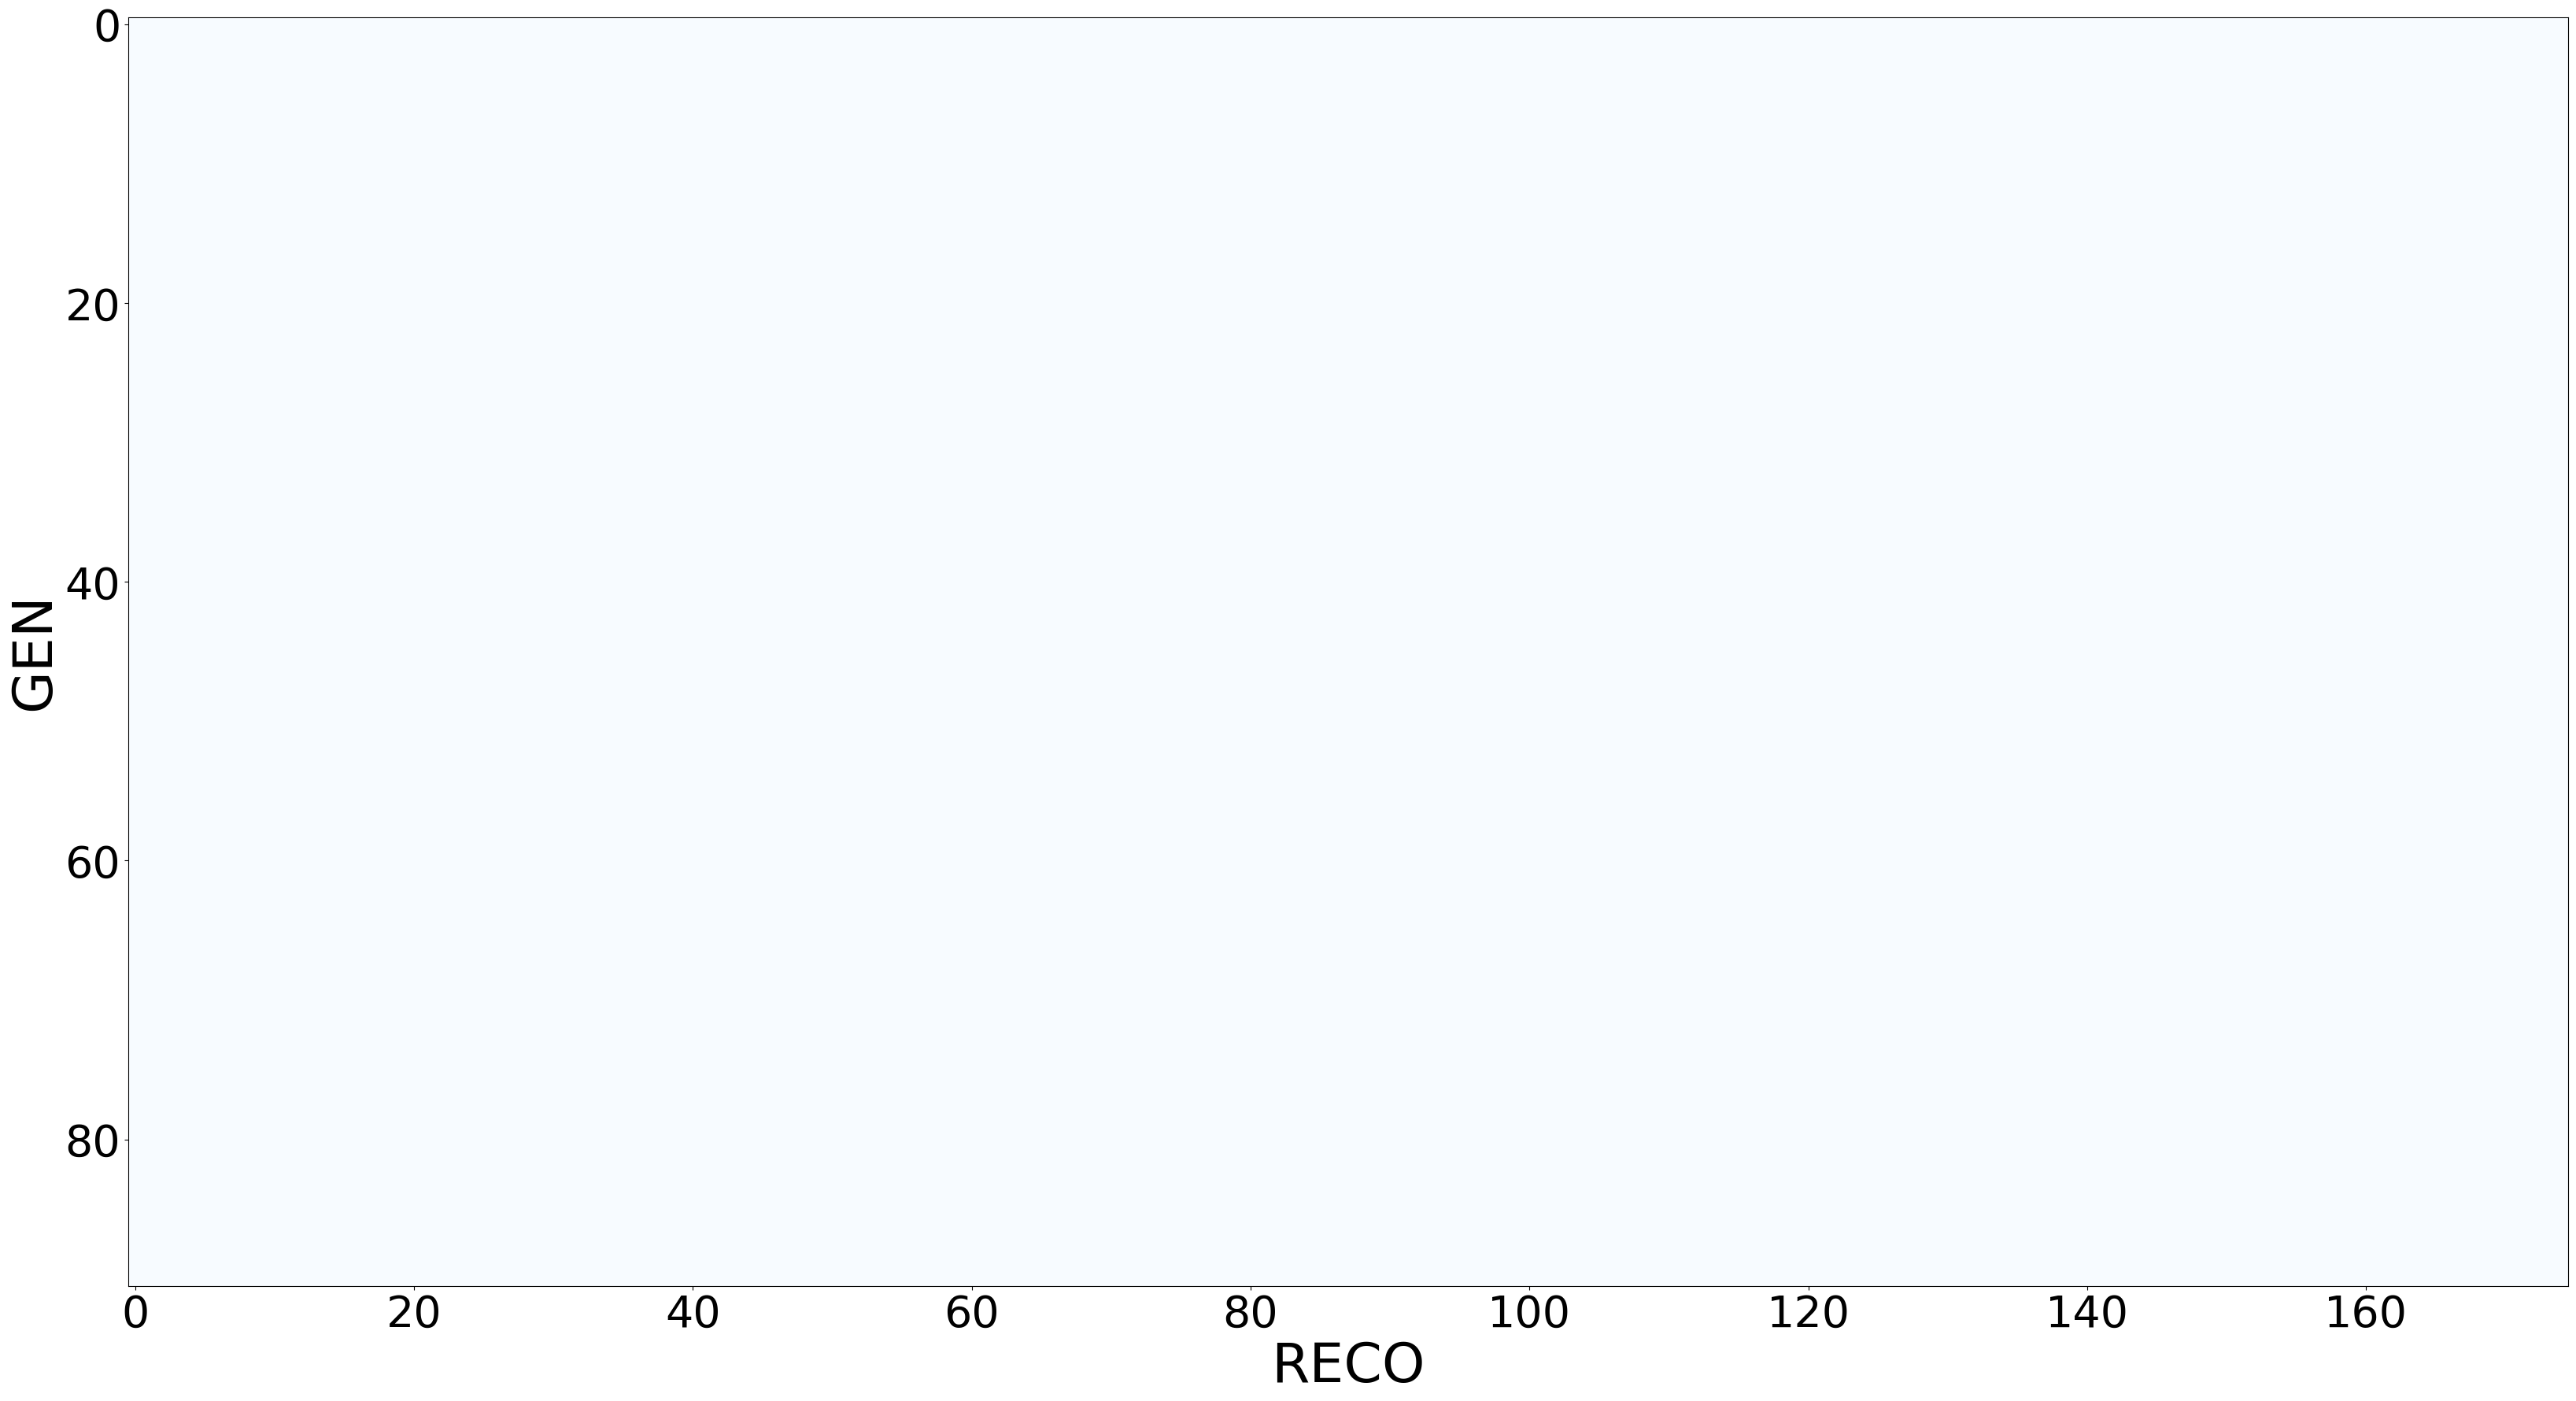

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize = (40,80))
plt.imshow( np.log(response_matrix_u_final+1), vmax=10, aspect="equal", cmap="Blues" )
plt.xlabel("RECO", fontsize=50)
plt.ylabel("GEN", fontsize=50)
plt.tick_params(labelsize=40)

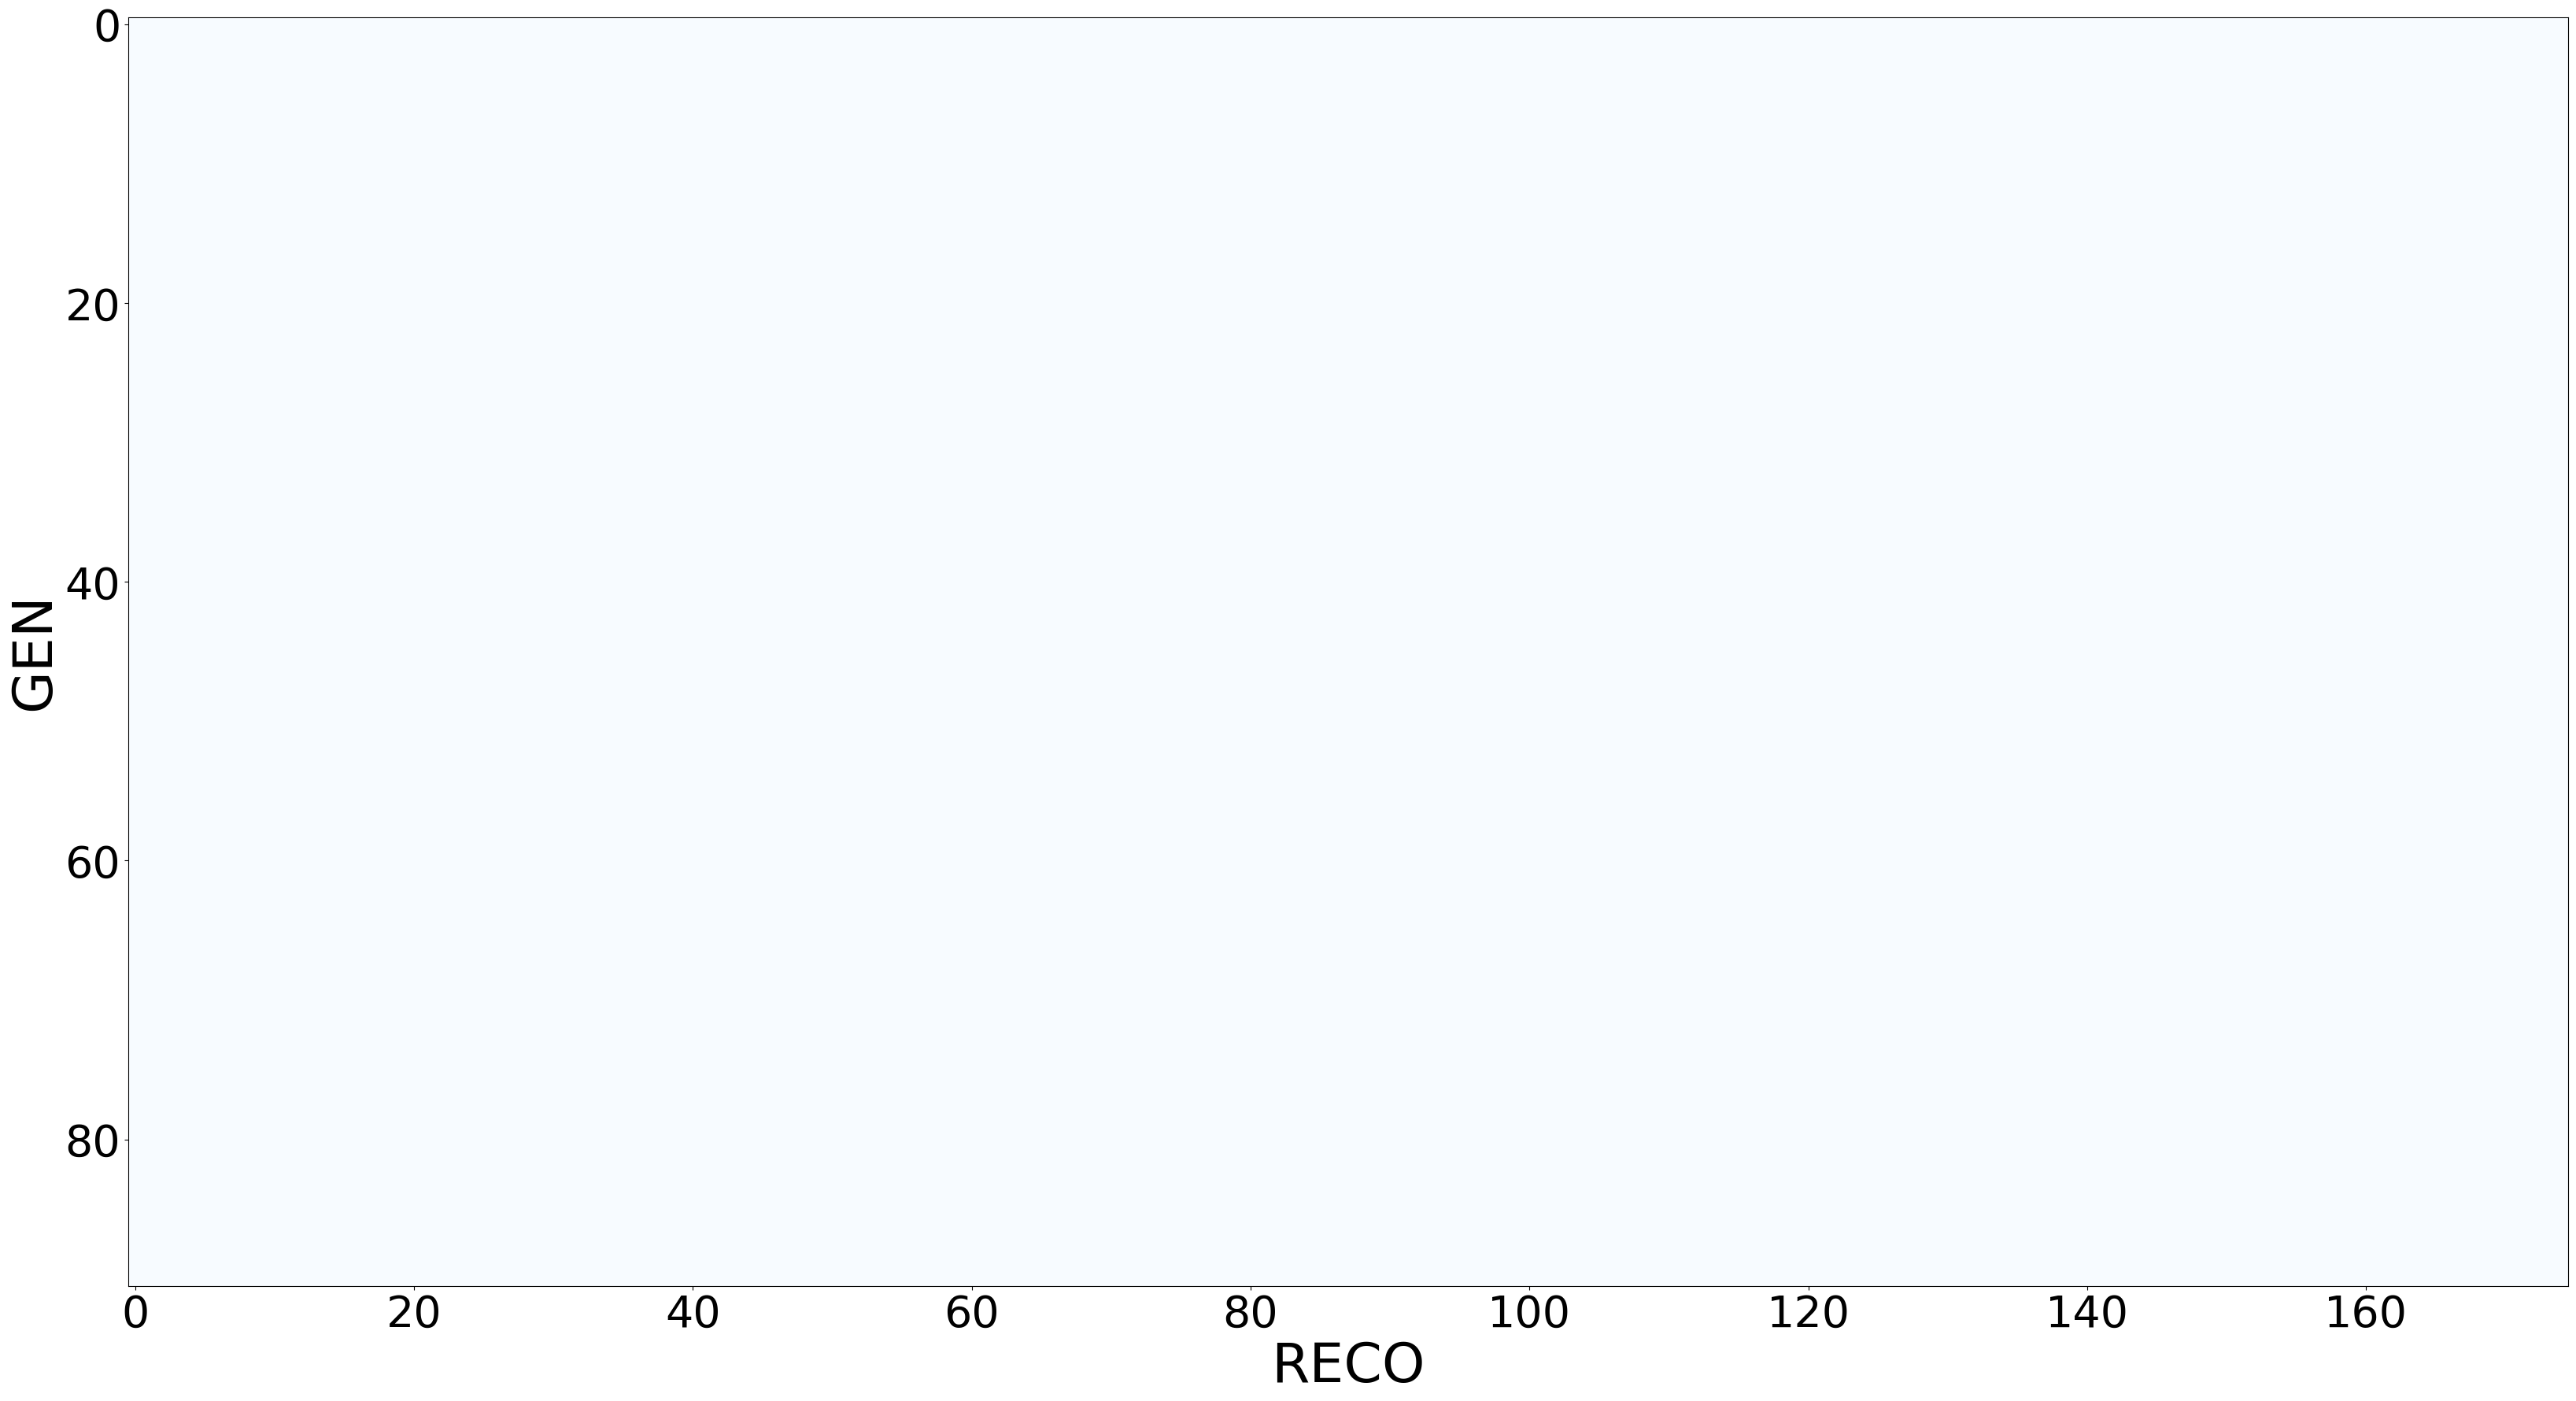

In [31]:
plt.figure(figsize = (40,80))
plt.imshow( np.log(response_matrix_g_final+1), vmax=10, aspect="equal", cmap="Blues" )
plt.xlabel("RECO", fontsize=50)
plt.ylabel("GEN", fontsize=50)
plt.tick_params(labelsize=40)

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 31312058.0: TOOL at 131.225.189.103 failed to send file(s) to <131.225.204.62:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpbpuvxe14/correctionFiles/JEC/Summer19UL16_V7_MC/Summer19UL16_V7_MC_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.204.62 - |Error: receiving file /storage/local/data1/condor/spool/2058/0/cluster31312058.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL16_V7_MC/Summer19UL16_V7_MC_L1FastJet_AK8PFPuppi.jec.txt
DCSchedd::spoolJobFiles:7002:File transfer failed for target job 31312059.0: TOOL at 131.225.189.103 failed to send file(s) to <131.225.204.62:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpbpuvxe14/.env/bin/python3; SCHEDD at 131.225.204.62 - |Error: receiving file /storage/local/data1/condor/spool/2059/0/cluster31312059.proc0.subproc0.tmp/.env/bin/python
DCSchedd::spoolJobFiles:7002:File transfer failed for target job 31312060.0: TOOL at 13

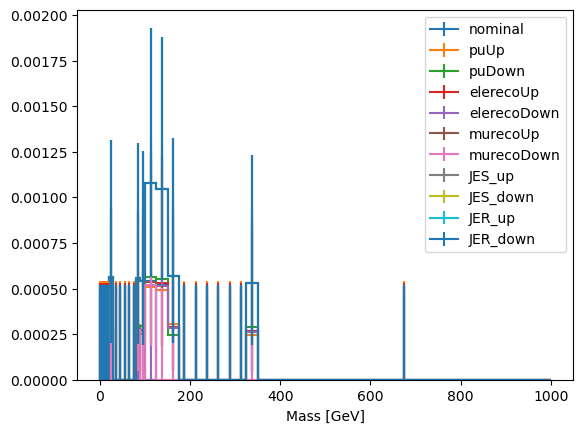

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 31312062.0: TOOL at 131.225.189.103 failed to send file(s) to <131.225.204.62:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpbpuvxe14/correctionFiles/JEC/Summer19UL17_RunD_V5_DATA/Summer19UL17_RunD_V5_DATA_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.204.62 - |Error: receiving file /storage/local/data1/condor/spool/2062/0/cluster31312062.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunD_V5_DATA/Summer19UL17_RunD_V5_DATA_L2Relative_AK8PF.jec.txt
Failed to commit and disconnect from queue.
DCSchedd::spoolJobFiles:7002:File transfer failed for target job 31312070.0: TOOL at 131.225.189.103 failed to send file(s) to <131.225.204.62:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpbpuvxe14/correctionFiles/JEC/Summer19UL18_RunA_V5_DATA/Summer19UL18_RunA_V5_DATA_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.204.62 - |Error: receiving file /storage/local/da

In [19]:
import matplotlib.pyplot as plt
output['response_matrix_u'].project("systematic","mgen").plot()
plt.legend()

(7, 7)